<a href="https://colab.research.google.com/github/Caterina1996/SFEW_dataset/blob/master/FACES_SFEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **FACES DATASET NOTEBOOK**

Entrenamos el modelo base con el dataset FACES y guardamos el modelo

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
!rm -rf Train2
!rm -rf Test2

!unzip "/content/gdrive/My Drive/Train2.zip"
!unzip "/content/gdrive/My Drive/Test2.zip"

Archive:  /content/gdrive/My Drive/Train2.zip
   creating: Train2/
   creating: Train2/Anger/
  inflating: Train2/Anger/004_o_m_a_b.jpg  
  inflating: Train2/Anger/005_o_f_a_b.jpg  
  inflating: Train2/Anger/006_m_f_a_b.jpg  
  inflating: Train2/Anger/007_m_m_a_b.jpg  
  inflating: Train2/Anger/008_y_m_a_b.jpg  
  inflating: Train2/Anger/010_y_f_a_b.jpg  
  inflating: Train2/Anger/011_m_f_a_b.jpg  
  inflating: Train2/Anger/012_o_f_a_b.jpg  
  inflating: Train2/Anger/013_y_m_a_b.jpg  
  inflating: Train2/Anger/014_m_m_a_b.jpg  
  inflating: Train2/Anger/015_o_m_a_b.jpg  
  inflating: Train2/Anger/016_y_m_a_b.jpg  
  inflating: Train2/Anger/018_o_m_a_b.jpg  
  inflating: Train2/Anger/019_m_f_a_b.jpg  
  inflating: Train2/Anger/020_y_f_a_b.jpg  
  inflating: Train2/Anger/021_o_f_a_b.jpg  
  inflating: Train2/Anger/022_y_f_a_b.jpg  
  inflating: Train2/Anger/024_o_f_a_b.jpg  
  inflating: Train2/Anger/025_y_m_a_b.jpg  
  inflating: Train2/Anger/026_m_m_a_b.jpg  
  inflating: Train2/Anger/

In [ ]:
import operator

import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, BatchNormalization, MaxPooling2D
from keras import applications

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
import tensorflow as tf


In [ ]:
tf.compat.v1.set_random_seed(1234)
from numpy.random import seed
seed(21)

import tensorflow
tensorflow.random.set_seed(21)

In [ ]:
#PARAMS

img_width, img_height =128, 128

LR = 0.00001
epochs = 100
batch_size = 1

num_classes=6
dropout = 0.25

train_dir='Train2'
test_dir='Test2'

In [ ]:
! ls SFEW_dataset/Train

Angry  Disgust	Fear  Happy  Neutral  Sad  Surprise


In [ ]:
! ls Train2

Anger  Disgust	Fear  Happiness  Neutrality  Sadness


Todas las emociones del FACES son comunes al SFEW


In [ ]:
# 1) Entrenamos usando la arquitectura base con el FACES 

In [ ]:
datagen = ImageDataGenerator(rescale=1. / 255)

train_set = datagen.flow_from_directory(
    train_dir,
    #classes=['Anger','Disgust','Fear','Happiness','Sadness'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True)

nb_train_samples = len(train_set.filenames)

test_set = datagen.flow_from_directory(
    test_dir,
    # classes=['Anger','Disgust','Fear','Happiness','Sadness'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True)

nb_test_samples = len(test_set.filenames)

Found 1026 images belonging to 6 classes.
Found 1026 images belonging to 6 classes.


**Modelo base:**

In [ ]:
def CNNmodel():
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), 
                     input_shape = ( img_height, img_width,1), 
                     activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))#--
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3),activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout*2))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    return model

In [ ]:
from keras.callbacks import ModelCheckpoint,CSVLogger
filepath="/content/gdrive/My Drive/FACES_SFEW/Test2/:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                              min_delta=0,
                                              patience=40,
                                              verbose=1,
                                              mode="auto",
                                              restore_best_weights=True)

csv_logger = CSVLogger('/content/gdrive/My Drive/TFM_MUSI/training.log')
callbacks_list = [checkpoint,E_stopping]

In [ ]:
Classifier=CNNmodel()
opt=keras.optimizers.SGD(lr=LR)
Classifier.compile(optimizer=opt,
                  loss='categorical_crossentropy', metrics=['categorical_accuracy','accuracy'])

Classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 61, 64)        0

In [ ]:
def plot_model(history,title):
  plt.figure()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  # plt.plot(history.history['val_categorical_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')

  plt.title("model train and val accuracy "+title)
  # plt.show()
  
  plt.figure()
  plt.plot(history.history['val_accuracy'])
  plt.title("Validation accuracy " + title)

  plt.figure()
  plt.plot(history.history['val_categorical_accuracy'])
  plt.title("Validation categorical accuracy"+title)
  # print(history.history.keys())

### **Entrenamiento del modelo base con el FACES**

In [ ]:
history=Classifier.fit_generator(train_set,
                         steps_per_epoch = nb_train_samples//batch_size,
                         epochs = 75,
                         validation_data = test_set,
                         validation_steps = nb_test_samples//batch_size,
                         callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/75
1026/1026 [==============================] - 321s 306ms/step - loss: 2.8706 - categorical_accuracy: 0.1976 - accuracy: 0.1976 - val_loss: 1.6090 - val_categorical_accuracy: 0.3606 - val_accuracy: 0.3606

Epoch 00001: val_accuracy improved from -inf to 0.36062, saving model to /content/gdrive/My Drive/FACES_SFEW/Test2/:001-val_acc:0.361.hdf5
Epoch 2/75
1026/1026 [==============================] - 297s 290ms/step - loss: 1.9601 - categorical_accuracy: 0.3377 - accuracy: 0.3377 - val_loss: 1.4900 - val_categorical_accuracy: 0.3938 - val_accuracy: 0.3938

Epoch 00002: val_accuracy improved from 0.36062 to 0.39376, saving model to /content/gdrive/My Drive/FACES_SFEW/Test2/:002-val_acc:0.394.hdf5
Epoch 3/75
1026/1026 [==============================] - 293s 285ms/step - loss: 1.8039 - categorical_accuracy: 0.3808 - accuracy: 0.3808 - val_loss: 1.3657 - val_categorical_accuracy: 0.4854 - val_accuracy: 0.4854

Epoch 00003: val_accuracy improved from 0.39376 to 0.48538, saving model t

In [ ]:
#Guardamos el modelo obtenido:

**Gràfica del resultado**

**Figura 6:** Train y validation accuracy obtenida por el modelo entrenado con el FACES

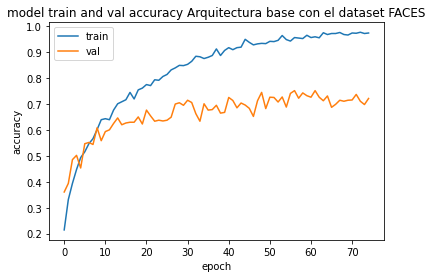

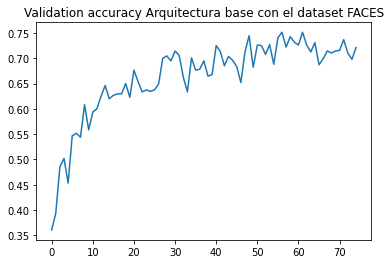

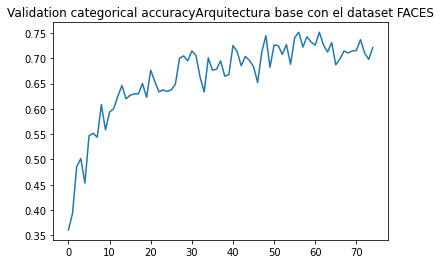

In [ ]:
import os
dir="/content/gdrive/MyDrive/TF_VGG16/FACES_SFEW/Test2/"
Classifier.save(dir+"FACES_SFEW.h5")
if os.path.exists(dir)==False:
  os.makedirs(dir)
Classifier.save(dir+"FACES_SFEW.h5")
title="Arquitectura base con el dataset FACES"
plot_model(history,title)

In [ ]:
Classifier.save('emotionsFACES.h5')

In [ ]:
Classifier.save('modelo_base_FACES.h5') # guardamos el modelo 

### **Test**

In [ ]:
#Test del modelo:

In [ ]:
#Cargamos el modelo obtenido y lo testeamos con los dos datasets:

In [ ]:
#Testeamos el modelo con el FACES i con el SFEW:
datagen = ImageDataGenerator(rescale=1. / 255)
test_set = datagen.flow_from_directory(
    'Test2',
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False)

a = Classifier.evaluate(test_set,steps=16)
print(a)
# print(test_loss," ",test_acc)

predictions=Classifier.predict(test_set)

print('Confusion Matrix')
ypred=[round(list(i).index(max(i))) for i in predictions]
print(confusion_matrix(test_set.classes, ypred)[:,:])
print(test_set.label_indices)

In [ ]:
emofaces6=load_model('6emotionsFACES.h5')

In [ ]:
import os
dir="/content/gdrive/MyDrive/TF_VGG16/FACES_SFEW/Test2/"
emofaces6=load_model(dir+"FACES_SFEW.h5")

In [ ]:
#Testeamos el modelo con el FACES i con el SFEW:
datagen = ImageDataGenerator(rescale=1. / 255)
test_set = datagen.flow_from_directory(
    'Test2',
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False)

a = emofaces6.evaluate(test_set,steps=16)
print(a)
# print(test_loss," ",test_acc)

predictions=emofaces6.predict(test_set)

print('Confusion Matrix')
ypred=[round(list(i).index(max(i))) for i in predictions]
print(confusion_matrix(test_set.classes, ypred)[:,:])

Found 1026 images belonging to 6 classes.
16/16 [==============================] - 10s 194ms/step - loss: 0.7039 - categorical_accuracy: 0.7500 - accuracy: 0.7500
[0.7039162516593933, 0.75, 0.75]
Confusion Matrix
[[132   4   0   0  26   9]
 [ 14 102   2   0  41  12]
 [  1   1 133   1  34   1]
 [  3   0   4 132  31   1]
 [  0   0   0   0 171   0]
 [ 15   3   4   1  78  70]]


In [ ]:
print(test_set.class_indices)
emotions_dict = {v: k for k, v in test_set.class_indices.items()}
print(emotions_dict)

{'Anger': 0, 'Disgust': 1, 'Fear': 2, 'Happiness': 3, 'Neutrality': 4, 'Sadness': 5}
{0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Neutrality', 5: 'Sadness'}


In [ ]:
datagen = ImageDataGenerator(rescale=1. / 255)

train_set = datagen.flow_from_directory(
    "SFEW_dataset/Train",
    classes=['Angry','Disgust','Fear','Happy','Neutral','Sad'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True)

nb_train_samples = len(train_set.filenames)

test_set = datagen.flow_from_directory(
    "SFEW_dataset/Val",
    classes=['Angry','Disgust','Fear','Happy','Neutral','Sad'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True)

nb_test_samples = len(test_set.filenames)

Found 766 images belonging to 6 classes.
Found 356 images belonging to 6 classes.


In [ ]:
#Reentrenamiento del modelo
from keras.callbacks import ModelCheckpoint,CSVLogger
filepath="/content/gdrive/My Drive/FACES_SFEW/SFEW_training/:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
if os.path.exists(filepath)==False:
  os.makedirs(filepath)

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                              min_delta=0,
                                              patience=40,
                                              verbose=1,
                                              mode="auto",
                                              restore_best_weights=True)

# csv_logger = CSVLogger('/content/gdrive/My Drive/TFM_MUSI/training.log')
callbacks_list = [checkpoint,E_stopping]

In [ ]:
history=emofaces6.fit_generator(train_set,
                         steps_per_epoch = nb_train_samples//batch_size,#nb_train_samples//batch_size,
                         epochs = 75,
                         validation_data = test_set,
                         validation_steps = nb_test_samples//batch_size,#nb_test_samples//batch_size,
                         callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/75
766/766 [==============================] - 7s 9ms/step - loss: 3.5419 - categorical_accuracy: 0.2441 - accuracy: 0.2441 - val_loss: 2.5303 - val_categorical_accuracy: 0.1910 - val_accuracy: 0.1910

Epoch 00001: val_accuracy did not improve from 0.20225
Epoch 2/75
766/766 [==============================] - 6s 8ms/step - loss: 2.1687 - categorical_accuracy: 0.3642 - accuracy: 0.3642 - val_loss: 2.4870 - val_categorical_accuracy: 0.1882 - val_accuracy: 0.1882

Epoch 00002: val_accuracy did not improve from 0.20225
Epoch 3/75
766/766 [==============================] - 6s 8ms/step - loss: 1.7594 - categorical_accuracy: 0.4204 - accuracy: 0.4204 - val_loss: 2.4116 - val_categorical_accuracy: 0.2275 - val_accuracy: 0.2275

Epoch 00003: val_accuracy improved from 0.20225 to 0.22753, saving model to /content/gdrive/My Drive/FACES_SFEW/SFEW_training/:003-val_acc:0.228.hdf5
Epoch 4/75
766/766 [==============================] - 6s 8ms/step - loss: 1.4637 - categorical_accuracy: 0.4948 -

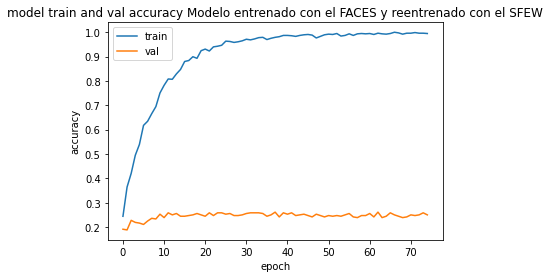

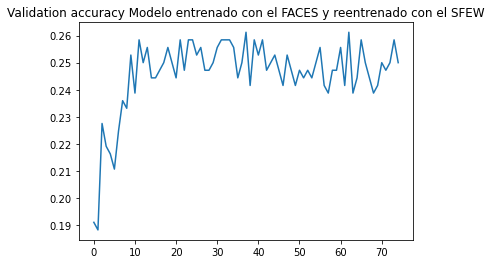

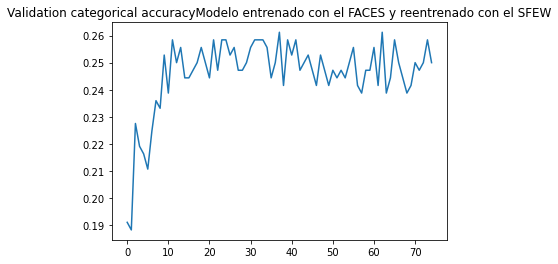

In [ ]:
emofaces6.save(dir+"SFEW_6_emo.h5")
title="Modelo entrenado con el FACES y reentrenado con el SFEW"
plot_model(history,title)


In [ ]:
#Testeamos el modelo con el FACES i con el SFEW:
datagen = ImageDataGenerator(rescale=1. / 255)
test_set = datagen.flow_from_directory(
    'SFEW_dataset/Val',
    classes=['Angry','Disgust','Fear','Happy','Neutral','Sad'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False)

a = emofaces6.evaluate(test_set,steps=16)
print(a)
# print(test_loss," ",test_acc)

predictions=emofaces6.predict(test_set)

print('Confusion Matrix')
ypred=[round(list(i).index(max(i))) for i in predictions]
print(confusion_matrix(test_set.classes, ypred)[:,:])


Found 356 images belonging to 6 classes.
16/16 [==============================] - 0s 4ms/step - loss: 2.8744 - categorical_accuracy: 0.1250 - accuracy: 0.1250
[2.8744049072265625, 0.125, 0.125]
Confusion Matrix
[[16  6  3  5 38  8]
 [ 8  2  0  2  6  5]
 [15  3  1  4  9 13]
 [13  7  1 22 11  8]
 [18  8  2  3 30 21]
 [ 7  9  4  3 27 18]]


In [ ]:
print(test_set.class_indices)
emotions_dict = {v: k for k, v in test_set.class_indices.items()}
print(emotions_dict)

{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5}
{0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad'}


In [ ]:
#Dataug

import os
dir="/content/gdrive/MyDrive/TF_VGG16/FACES_SFEW/Test2/"
FACES_SFEW_model=load_model(dir+"FACES_SFEW.h5")

In [ ]:
FACES_SFEW_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 61, 64)        0

In [ ]:
datagen = ImageDataGenerator(rescale=1. / 255)

train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   brightness_range=[0.5,1.0],
                                   zoom_range=0.1,
                                   shear_range=0.2,
                                  #  height_shift_range=0.1,
                                   horizontal_flip=True)
                                  #  height_shift_range=0.1

train_set = train_datagen.flow_from_directory(
    "SFEW_dataset/Train",
    classes=['Angry','Disgust','Fear','Happy','Neutral','Sad'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True)

nb_train_samples = len(train_set.filenames)

test_set = datagen.flow_from_directory(
    "SFEW_dataset/Val",
    classes=['Angry','Disgust','Fear','Happy','Neutral','Sad'],
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True)

nb_test_samples = len(test_set.filenames)

Found 766 images belonging to 6 classes.
Found 356 images belonging to 6 classes.


In [ ]:
from keras.callbacks import ModelCheckpoint,CSVLogger
filepath="/content/gdrive/My Drive/FACES_SFEW/Dataug/:{epoch:03d}-val_acc:{val_accuracy:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

E_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                              min_delta=0,
                                              patience=25,
                                              verbose=1,
                                              mode="auto",
                                              restore_best_weights=False)

callbacks_list = [checkpoint,E_stopping]

In [ ]:
history=FACES_SFEW_model.fit_generator(train_set,
                         steps_per_epoch = nb_train_samples//batch_size,#nb_train_samples//batch_size,
                         epochs = 100,
                         validation_data = test_set,
                         validation_steps = nb_test_samples)
                        #  callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
766/766 [==============================] - 7s 9ms/step - loss: 3.6207 - categorical_accuracy: 0.2585 - accuracy: 0.2585 - val_loss: 2.4312 - val_categorical_accuracy: 0.1882 - val_accuracy: 0.1882
Epoch 2/100
766/766 [==============================] - 7s 9ms/step - loss: 2.5683 - categorical_accuracy: 0.2950 - accuracy: 0.2950 - val_loss: 2.2537 - val_categorical_accuracy: 0.2107 - val_accuracy: 0.2107
Epoch 3/100
766/766 [==============================] - 7s 9ms/step - loss: 2.1463 - categorical_accuracy: 0.3473 - accuracy: 0.3473 - val_loss: 2.2148 - val_categorical_accuracy: 0.2079 - val_accuracy: 0.2079
Epoch 4/100
766/766 [==============================] - 7s 9ms/step - loss: 1.9497 - categorical_accuracy: 0.3564 - accuracy: 0.3564 - val_loss: 2.1694 - val_categorical_accuracy: 0.2079 - val_accuracy: 0.2079
Epoch 5/100
766/766 [==============================] - 7s 8ms/step - loss: 1.7717 - categorical_accuracy: 0.3838 - accuracy: 0.3838 - val_loss: 2.1213 - val_categor

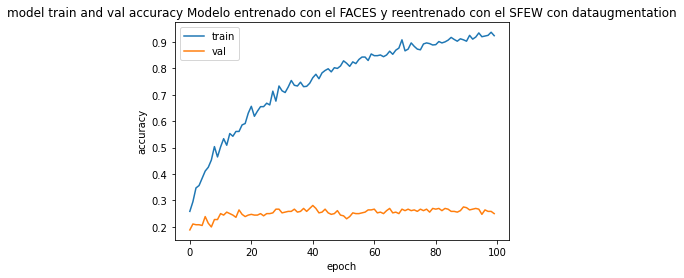

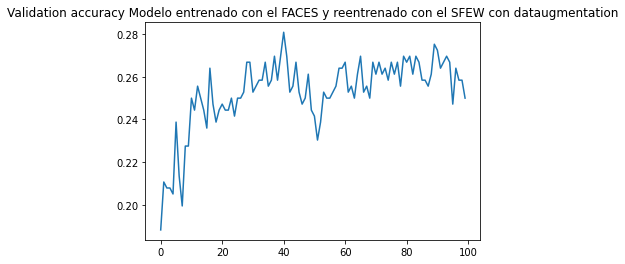

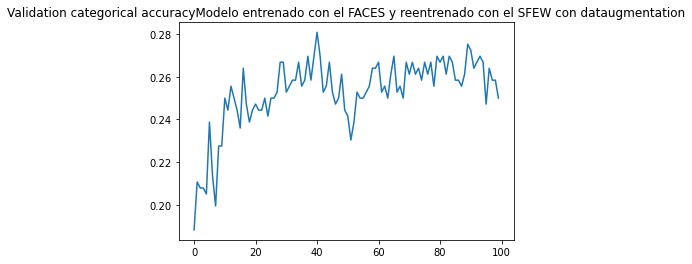

In [ ]:
dir="/content/gdrive/My Drive/FACES_SFEW/Dataug/"
FACES_SFEW_model.save(dir+"SFEW_6_emo_dataug.h5")
title="Modelo entrenado con el FACES y reentrenado con el SFEW con dataugmentation"
plot_model(history,title)

In [ ]:
#Testeamos el modelo con el FACES i con el SFEW:
test_set = datagen.flow_from_directory(
    'SFEW_dataset/Val',
    target_size=(img_width, img_height),
    batch_size=1,
    classes=['Angry','Disgust','Fear','Happy','Sad','Neutral'],
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False)

predictions=FACES_SFEW_model.predict(test_set)

print('Confusion Matrix')
ypred=[round(list(i).index(max(i))) for i in predictions]
print(confusion_matrix(test_set.classes, ypred)[:,:])

FACES_SFEW_model.evaluate_generator(test_set)
test_set.class_indices

Found 356 images belonging to 6 classes.
Confusion Matrix
[[11  2  1  4 56  2]
 [ 3  2  0  3 14  1]
 [ 2  1  0  4 24 14]
 [ 7  7  2 13 28  5]
 [ 3  4  2  6 44  9]
 [ 2  6  0  4 54 16]]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 5, 'Sad': 4}